# Method 3 - Best Ideas Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

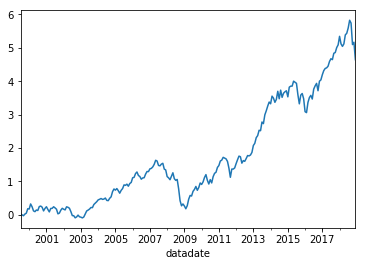

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.181088
2000-12-31    0.008528
2001-12-31    0.002699
2002-12-31   -0.212874
2003-12-31    0.480681
2004-12-31    0.273709
2005-12-31    0.110886
2006-12-31    0.164715
2007-12-31    0.021498
2008-12-31   -0.434611
2009-12-31    0.473853
2010-12-31    0.238429
2011-12-31   -0.006237
2012-12-31    0.192802
2013-12-31    0.526784
2014-12-31    0.076936
2015-12-31   -0.050644
2016-12-31    0.125950
2017-12-31    0.208180
2018-12-31   -0.072907
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     662.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.38e-124
Time:                        12:59:08   Log-Likelihood:                 661.20
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1295.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.555      0.000       0.002       0.005
mktrf          0.9406      0.027     34.788      0.000       0.887       0.994
me             0.4481      0.031     14.248      0.000       0.386       0.510
ia             0.0044      0.048      0.093      0.926      -0.090       0.099
roe           -0.0822      0.041     -2.010      0.046      -0.163      -0.002
==============================================================================
Omnibus:                       15.631   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.943
Skew:                          -0.019   Prob(JB):                     1.06e-10
Kurtosis:                       5.170   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     661.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.54e-124
Time:                        12:59:08   Log-Likelihood:                 661.20
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1295.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.887      0.000       0.002       0.005
mktrf          0.9406      0.033     28.511      0.000       0.876       1.005
me             0.4481      0.032     14.190      0.000       0.386       0.510
ia             0.0044      0.084      0.053      0.958      -0.161       0.170
roe           -0.0822      0.052     -1.587      0.112      -0.184       0.019
==============================================================================
Omnibus:                       15.631   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.943
Skew:                          -0.019   Prob(JB):                     1.06e-10
Kurtosis:                       5.170   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     833.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.61e-135
Time:                        12:59:08   Log-Likelihood:                 661.20
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1295.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.971      0.000       0.002       0.005
mktrf          0.9406      0.027     34.835      0.000       0.888       0.994
me             0.4481      0.030     14.795      0.000       0.389       0.507
ia             0.0044      0.094      0.047      0.962      -0.180       0.189
roe           -0.0822      0.045     -1.815      0.070      -0.171       0.007
==============================================================================
Omnibus:                       15.631   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.943
Skew:                          -0.019   Prob(JB):                     1.06e-10
Kurtosis:                       5.170   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     453.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.06e-116
Time:                        12:59:08   Log-Likelihood:                 644.86
No. Observations:                 234   AIC:                            -1278.
Df Residuals:                     228   BIC:                            -1257.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.965      0.003       0.001       0.005
mktrf          0.9642      0.029     33.117      0.000       0.907       1.022
smb            0.4802      0.038     12.499      0.000       0.404       0.556
hml            0.0036      0.045      0.080      0.936      -0.086       0.093
rmw           -0.0403      0.051     -0.787      0.432      -0.141       0.061
cma            0.0482      0.065      0.740      0.460      -0.080       0.176
==============================================================================
Omnibus:                       11.919   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               28.077
Skew:                          -0.022   Prob(JB):                     8.00e-07
Kurtosis:                       4.696   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     459.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.15e-117
Time:                        12:59:08   Log-Likelihood:                 644.86
No. Observations:                 234   AIC:                            -1278.
Df Residuals:                     228   BIC:                            -1257.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.898      0.004       0.001       0.005
mktrf          0.9642      0.039     24.686      0.000       0.888       1.041
smb            0.4802      0.037     12.939      0.000       0.407       0.553
hml            0.0036      0.080      0.045      0.964      -0.153       0.160
rmw           -0.0403      0.066     -0.613      0.540      -0.169       0.089
cma            0.0482      0.112      0.429      0.668      -0.172       0.269
==============================================================================
Omnibus:                       11.919   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               28.077
Skew:                          -0.022   Prob(JB):                     8.00e-07
Kurtosis:                       4.696   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     628.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.93e-131
Time:                        12:59:08   Log-Likelihood:                 644.86
No. Observations:                 234   AIC:                            -1278.
Df Residuals:                     228   BIC:                            -1257.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.733      0.006       0.001       0.005
mktrf          0.9642      0.037     25.735      0.000       0.891       1.038
smb            0.4802      0.035     13.821      0.000       0.412       0.548
hml            0.0036      0.083      0.044      0.965      -0.158       0.166
rmw           -0.0403      0.063     -0.638      0.523      -0.164       0.084
cma            0.0482      0.124      0.388      0.698      -0.195       0.292
==============================================================================
Omnibus:                       11.919   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               28.077
Skew:                          -0.022   Prob(JB):                     8.00e-07
Kurtosis:                       4.696   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     529.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.96e-114
Time:                        12:59:08   Log-Likelihood:                 637.30
No. Observations:                 234   AIC:                            -1265.
Df Residuals:                     229   BIC:                            -1247.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.871      0.004       0.001       0.005
mktrf          0.9825      0.028     35.634      0.000       0.928       1.037
smb            0.4550      0.034     13.221      0.000       0.387       0.523
hml            0.1071      0.034      3.134      0.002       0.040       0.175
umd            0.0187      0.022      0.834      0.405      -0.026       0.063
==============================================================================
Omnibus:                       16.171   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.072
Skew:                           0.001   Prob(JB):                     2.21e-11
Kurtosis:                       5.243   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     583.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.28e-119
Time:                        12:59:08   Log-Likelihood:                 637.30
No. Observations:                 234   AIC:                            -1265.
Df Residuals:                     229   BIC:                            -1247.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.691      0.007       0.001       0.005
mktrf          0.9825      0.036     27.295      0.000       0.912       1.053
smb            0.4550      0.035     13.051      0.000       0.387       0.523
hml            0.1071      0.071      1.507      0.132      -0.032       0.246
umd            0.0187      0.033      0.575      0.565      -0.045       0.082
==============================================================================
Omnibus:                       16.171   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.072
Skew:                           0.001   Prob(JB):                     2.21e-11
Kurtosis:                       5.243   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     847.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.38e-136
Time:                        12:59:08   Log-Likelihood:                 637.30
No. Observations:                 234   AIC:                            -1265.
Df Residuals:                     229   BIC:                            -1247.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.760      0.006       0.001       0.005
mktrf          0.9825      0.032     30.411      0.000       0.919       1.046
smb            0.4550      0.029     15.856      0.000       0.399       0.511
hml            0.1071      0.076      1.413      0.158      -0.041       0.256
umd            0.0187      0.029      0.645      0.519      -0.038       0.076
==============================================================================
Omnibus:                       16.171   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.072
Skew:                           0.001   Prob(JB):                     2.21e-11
Kurtosis:                       5.243   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     268.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-57
Time:                        12:59:08   Log-Likelihood:                 313.99
No. Observations:                 120   AIC:                            -618.0
Df Residuals:                     115   BIC:                            -604.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.377      0.019       0.001       0.008
mktrf          0.9489      0.047     20.388      0.000       0.857       1.041
me             0.4519      0.046      9.831      0.000       0.361       0.543
ia             0.0300      0.072      0.417      0.677      -0.113       0.173
roe           -0.0496      0.064     -0.779      0.438      -0.176       0.077
==============================================================================
Omnibus:                        4.801   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                6.236
Skew:                          -0.121   Prob(JB):                       0.0442
Kurtosis:                       4.090   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     431.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.06e-68
Time:                        12:59:08   Log-Likelihood:                 313.99
No. Observations:                 120   AIC:                            -618.0
Df Residuals:                     115   BIC:                            -604.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      2.869      0.004       0.001       0.007
mktrf          0.9489      0.061     15.440      0.000       0.828       1.069
me             0.4519      0.040     11.334      0.000       0.374       0.530
ia             0.0300      0.101      0.296      0.767      -0.169       0.229
roe           -0.0496      0.081     -0.613      0.540      -0.208       0.109
==============================================================================
Omnibus:                        4.801   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                6.236
Skew:                          -0.121   Prob(JB):                       0.0442
Kurtosis:                       4.090   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     627.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.45e-77
Time:                        12:59:08   Log-Likelihood:                 313.99
No. Observations:                 120   AIC:                            -618.0
Df Residuals:                     115   BIC:                            -604.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      3.123      0.002       0.002       0.007
mktrf          0.9489      0.049     19.505      0.000       0.854       1.044
me             0.4519      0.039     11.661      0.000       0.376       0.528
ia             0.0300      0.111      0.270      0.787      -0.188       0.248
roe           -0.0496      0.068     -0.731      0.465      -0.183       0.083
==============================================================================
Omnibus:                        4.801   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                6.236
Skew:                          -0.121   Prob(JB):                       0.0442
Kurtosis:                       4.090   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     182.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-52
Time:                        12:59:09   Log-Likelihood:                 305.59
No. Observations:                 120   AIC:                            -599.2
Df Residuals:                     114   BIC:                            -582.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.216      0.029       0.000       0.008
mktrf          1.0016      0.053     18.948      0.000       0.897       1.106
smb            0.5066      0.060      8.462      0.000       0.388       0.625
hml           -0.0313      0.073     -0.426      0.671      -0.177       0.114
rmw            0.0283      0.087      0.327      0.744      -0.143       0.200
cma            0.1063      0.095      1.122      0.264      -0.081       0.294
==============================================================================
Omnibus:                        3.502   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                3.367
Skew:                          -0.194   Prob(JB):                        0.186
Kurtosis:                       3.723   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     279.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.34e-62
Time:                        12:59:09   Log-Likelihood:                 305.59
No. Observations:                 120   AIC:                            -599.2
Df Residuals:                     114   BIC:                            -582.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.351      0.019       0.001       0.008
mktrf          1.0016      0.076     13.110      0.000       0.852       1.151
smb            0.5066      0.058      8.780      0.000       0.394       0.620
hml           -0.0313      0.130     -0.241      0.810      -0.286       0.223
rmw            0.0283      0.133      0.213      0.831      -0.232       0.289
cma            0.1063      0.140      0.758      0.448      -0.168       0.381
==============================================================================
Omnibus:                        3.502   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                3.367
Skew:                          -0.194   Prob(JB):                        0.186
Kurtosis:                       3.723   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     403.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-70
Time:                        12:59:09   Log-Likelihood:                 305.59
No. Observations:                 120   AIC:                            -599.2
Df Residuals:                     114   BIC:                            -582.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.305      0.021       0.001       0.008
mktrf          1.0016      0.074     13.456      0.000       0.856       1.148
smb            0.5066      0.056      9.091      0.000       0.397       0.616
hml           -0.0313      0.137     -0.228      0.820      -0.300       0.237
rmw            0.0283      0.138      0.206      0.837      -0.242       0.298
cma            0.1063      0.153      0.693      0.488      -0.194       0.407
==============================================================================
Omnibus:                        3.502   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                3.367
Skew:                          -0.194   Prob(JB):                        0.186
Kurtosis:                       3.723   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     211.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.44e-52
Time:                        12:59:09   Log-Likelihood:                 301.13
No. Observations:                 120   AIC:                            -592.3
Df Residuals:                     115   BIC:                            -578.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.002      2.519      0.013       0.001       0.008
mktrf          0.9951      0.046     21.804      0.000       0.905       1.086
smb            0.4528      0.052      8.713      0.000       0.350       0.556
hml            0.1316      0.052      2.528      0.013       0.028       0.235
umd            0.0237      0.032      0.739      0.461      -0.040       0.087
==============================================================================
Omnibus:                        5.548   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                7.638
Skew:                          -0.157   Prob(JB):                       0.0219
Kurtosis:                       4.196   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     388.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.26e-66
Time:                        12:59:09   Log-Likelihood:                 301.13
No. Observations:                 120   AIC:                            -592.3
Df Residuals:                     115   BIC:                            -578.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.002      2.783      0.005       0.001       0.008
mktrf          0.9951      0.057     17.402      0.000       0.883       1.107
smb            0.4528      0.048      9.493      0.000       0.359       0.546
hml            0.1316      0.090      1.467      0.142      -0.044       0.307
umd            0.0237      0.040      0.592      0.554      -0.055       0.102
==============================================================================
Omnibus:                        5.548   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                7.638
Skew:                          -0.157   Prob(JB):                       0.0219
Kurtosis:                       4.196   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     553.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.41e-74
Time:                        12:59:09   Log-Likelihood:                 301.13
No. Observations:                 120   AIC:                            -592.3
Df Residuals:                     115   BIC:                            -578.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.001      3.205      0.001       0.002       0.008
mktrf          0.9951      0.048     20.899      0.000       0.902       1.088
smb            0.4528      0.039     11.464      0.000       0.375       0.530
hml            0.1316      0.094      1.396      0.163      -0.053       0.316
umd            0.0237      0.032      0.739      0.460      -0.039       0.087
==============================================================================
Omnibus:                        5.548   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                7.638
Skew:                          -0.157   Prob(JB):                       0.0219
Kurtosis:                       4.196   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     634.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-74
Time:                        12:59:09   Log-Likelihood:                 377.67
No. Observations:                 114   AIC:                            -745.3
Df Residuals:                     109   BIC:                            -731.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.180      0.002       0.001       0.005
mktrf          0.9566      0.026     36.111      0.000       0.904       1.009
me             0.4073      0.041      9.960      0.000       0.326       0.488
ia            -0.1353      0.057     -2.385      0.019      -0.248      -0.023
roe           -0.2385      0.050     -4.785      0.000      -0.337      -0.140
==============================================================================
Omnibus:                        0.125   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.940   Jarque-Bera (JB):                0.034
Skew:                          -0.042   Prob(JB):                        0.983
Kurtosis:                       2.996   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     634.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.63e-74
Time:                        12:59:09   Log-Likelihood:                 377.67
No. Observations:                 114   AIC:                            -745.3
Df Residuals:                     109   BIC:                            -731.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.706      0.007       0.001       0.005
mktrf          0.9566      0.024     39.669      0.000       0.909       1.004
me             0.4073      0.037     11.045      0.000       0.335       0.480
ia            -0.1353      0.070     -1.941      0.052      -0.272       0.001
roe           -0.2385      0.041     -5.839      0.000      -0.319      -0.158
==============================================================================
Omnibus:                        0.125   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.940   Jarque-Bera (JB):                0.034
Skew:                          -0.042   Prob(JB):                        0.983
Kurtosis:                       2.996   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     742.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.37e-78
Time:                        12:59:09   Log-Likelihood:                 377.67
No. Observations:                 114   AIC:                            -745.3
Df Residuals:                     109   BIC:                            -731.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.454      0.014       0.001       0.005
mktrf          0.9566      0.023     40.956      0.000       0.911       1.002
me             0.4073      0.039     10.488      0.000       0.331       0.483
ia            -0.1353      0.077     -1.751      0.080      -0.287       0.016
roe           -0.2385      0.041     -5.881      0.000      -0.318      -0.159
==============================================================================
Omnibus:                        0.125   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.940   Jarque-Bera (JB):                0.034
Skew:                          -0.042   Prob(JB):                        0.983
Kurtosis:                       2.996   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     494.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.10e-72
Time:                        12:59:09   Log-Likelihood:                 376.77
No. Observations:                 114   AIC:                            -741.5
Df Residuals:                     108   BIC:                            -725.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.993      0.049    9.64e-06       0.004
mktrf          0.9699      0.026     37.911      0.000       0.919       1.021
smb            0.3958      0.042      9.530      0.000       0.313       0.478
hml           -0.0312      0.053     -0.588      0.558      -0.136       0.074
rmw           -0.3055      0.065     -4.710      0.000      -0.434      -0.177
cma           -0.0789      0.082     -0.958      0.340      -0.242       0.084
==============================================================================
Omnibus:                        0.338   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.845   Jarque-Bera (JB):                0.272
Skew:                          -0.118   Prob(JB):                        0.873
Kurtosis:                       2.960   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     387.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.95e-67
Time:                        12:59:09   Log-Likelihood:                 376.77
No. Observations:                 114   AIC:                            -741.5
Df Residuals:                     108   BIC:                            -725.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.651      0.099      -0.000       0.004
mktrf          0.9699      0.024     41.183      0.000       0.924       1.016
smb            0.3958      0.043      9.144      0.000       0.311       0.481
hml           -0.0312      0.056     -0.557      0.578      -0.141       0.079
rmw           -0.3055      0.055     -5.561      0.000      -0.413      -0.198
cma           -0.0789      0.098     -0.803      0.422      -0.271       0.114
==============================================================================
Omnibus:                        0.338   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.845   Jarque-Bera (JB):                0.272
Skew:                          -0.118   Prob(JB):                        0.873
Kurtosis:                       2.960   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     407.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.19e-68
Time:                        12:59:09   Log-Likelihood:                 376.77
No. Observations:                 114   AIC:                            -741.5
Df Residuals:                     108   BIC:                            -725.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.466      0.143      -0.001       0.004
mktrf          0.9699      0.024     40.192      0.000       0.923       1.017
smb            0.3958      0.042      9.447      0.000       0.314       0.478
hml           -0.0312      0.053     -0.593      0.553      -0.134       0.072
rmw           -0.3055      0.056     -5.455      0.000      -0.415      -0.196
cma           -0.0789      0.096     -0.822      0.411      -0.267       0.109
==============================================================================
Omnibus:                        0.338   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.845   Jarque-Bera (JB):                0.272
Skew:                          -0.118   Prob(JB):                        0.873
Kurtosis:                       2.960   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     497.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.04e-69
Time:                        12:59:09   Log-Likelihood:                 364.51
No. Observations:                 114   AIC:                            -719.0
Df Residuals:                     109   BIC:                            -705.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.095      0.276      -0.001       0.003
mktrf          0.9950      0.028     35.315      0.000       0.939       1.051
smb            0.4623      0.044     10.524      0.000       0.375       0.549
hml            0.0038      0.045      0.085      0.932      -0.086       0.094
umd           -0.0144      0.034     -0.420      0.675      -0.082       0.053
==============================================================================
Omnibus:                        0.528   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.664
Skew:                          -0.063   Prob(JB):                        0.718
Kurtosis:                       2.648   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     334.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.28e-60
Time:                        12:59:09   Log-Likelihood:                 364.51
No. Observations:                 114   AIC:                            -719.0
Df Residuals:                     109   BIC:                            -705.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.941      0.347      -0.001       0.003
mktrf          0.9950      0.029     34.103      0.000       0.938       1.052
smb            0.4623      0.048      9.688      0.000       0.369       0.556
hml            0.0038      0.056      0.069      0.945      -0.106       0.114
umd           -0.0144      0.035     -0.409      0.682      -0.083       0.054
==============================================================================
Omnibus:                        0.528   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.664
Skew:                          -0.063   Prob(JB):                        0.718
Kurtosis:                       2.648   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     359.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.59e-62
Time:                        12:59:09   Log-Likelihood:                 364.51
No. Observations:                 114   AIC:                            -719.0
Df Residuals:                     109   BIC:                            -705.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.873      0.383      -0.001       0.004
mktrf          0.9950      0.029     34.229      0.000       0.938       1.052
smb            0.4623      0.045     10.330      0.000       0.375       0.550
hml            0.0038      0.058      0.066      0.947      -0.110       0.118
umd           -0.0144      0.037     -0.383      0.702      -0.088       0.059
==============================================================================
Omnibus:                        0.528   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.664
Skew:                          -0.063   Prob(JB):                        0.718
Kurtosis:                       2.648   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""